# Python自动化报表分析

**说明**  
本脚本应当与CSMAR数据库配合，具体使用步骤：
1. 在CSMAR数据库中下载三张财务报表，并将excel文件置于同一文件夹中
2. 进入脚本块**1.1**
    - 写入目标公司代码、放置excel的文件夹路径
    - 可以更改主题色，颜色不宜太亮/太浅
3. 运行全部代码

**饼**  
-   自动加入副坐标轴
-   支持分析行业级数据

**更新日志**  
22-11-18.01：  
优化了一下index逻辑

## 1.   基础配置

In [113]:
#coding=utf-8
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# 色彩模块
import colorsys

In [114]:
# Matplotlib 设置
plt.rcParams['font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['lines.linewidth'] = '3'
plt.rcParams['axes.xmargin'] = 0.05

### 1.1. 写入个人配置

In [115]:
# 想要分析的上市公司代码
ID = '300240'

# 在r后面的引号中写入报表文件所在目录
path = r'E:/18082/Documents/9 CodeProjects/sheet'

# 写入想要的主题色
cm = '#9cc3e5'

### 1.2.    生成配色方案

In [116]:
def rgb2hsb(rgb):   # 转为 HSB 色值
    rgb = (int(rgb[1:3], 16), int(rgb[3:5], 16), int(rgb[5:], 16))
    hsv = colorsys.rgb_to_hsv(rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)

    return hsv

def hsb2rgb(h, s, b):   # 转回 RGB 色系
    rgb = colorsys.hsv_to_rgb(h, s, b)
    rgb = '#' + hex(int(rgb[0] * 255))[2:] + hex(int(rgb[1] * 255))[2:] + hex(int(rgb[2] * 255))[2:]

    return rgb  # 一个带#号的字符串

def lightcolor(rgb):    # 生成两个浅色
    hsb = rgb2hsb(rgb)

    if hsb[1] > 0.1:
        l2s = 0.1
    else:
        l2s = 0
    l1s = (l2s + hsb[1]) / 2

    if hsb[2] <= 0.99:
        l2b = 0.99
    else:
        l2b = 1
    l1b = (hsb[2] + l2b) / 2

    l1 = hsb2rgb(hsb[0], l1s, l1b)
    l2 = hsb2rgb(hsb[0], l2s, l2b)

    return [l1, l2]

def neighborcolor(rgb): # 生成两个相邻色
    hsb = rgb2hsb(rgb)

    h2 = hsb[1] + (1/3)
    if h2 > 1:
        h2 -= 1
    
    h3 = h2 + (1/3)
    if h3 > 1:
        h3 -= 1
    
    h2 = hsb2rgb(h2, hsb[1], hsb[2])
    h3 = hsb2rgb(h3, hsb[1], hsb[2])

    return [h2, h3]

cm_l1 = lightcolor(cm)[0]   # 生成两个浅色
cm_l2 = lightcolor(cm)[1]

# 两个相邻色
cn1 = neighborcolor(cm)[0]
cn2 = neighborcolor(cm)[1]

gray = '#d8d8d8'
black = '#000000'

## 2.   数据整理

In [117]:
def DataClean(filename):
    df = pd.read_excel(filename, sheet_name='sheet1', header=None)
    df.loc[1, 1] = '会计期间'
    df.columns = df.values.tolist()[1]
    df = df[df['会计期间'].apply(lambda x: x[5:7] == "12")]
    #df = df.set_index('会计期间')
    df = df[df['报表类型'].isin(['A'])].fillna(value=0)
    return df
def zoom(dataset):
    max_number = dataset.max().max()
    min_number = min(dataset.min().min(), 0)
    if max_number >= 1e9:
        dataset = dataset / 1e8   # 单位
        label = '（单位：亿元）'
    else:
        dataset = dataset / 1e4
        label = '（单位：万元）'
    
    return [dataset, label]

In [ ]:
os.chdir(path)
path_img = path + '/' + ID
if not os.path.exists(path_img):
    os.makedirs(path_img)

BalanceSheet = DataClean('FS_Combas.xlsx')
IncomeSheet = DataClean('FS_Comins.xlsx')
CashFlowSheet = DataClean('FS_Comscfd.xlsx')
TheSheet = pd.merge(BalanceSheet, IncomeSheet, on=['证券代码','会计期间'])
TheSheet = pd.merge(TheSheet, CashFlowSheet, on=['证券代码','会计期间'])

TheSheet = TheSheet[TheSheet['证券代码'].apply(lambda x: x == ID)]
for i in range(len(TheSheet)):
    TheSheet.iloc[i, 1] = TheSheet.iloc[i, 1][:4]
TheSheet = TheSheet.reset_index(drop=True)

x = TheSheet.loc[:, '会计期间']
barwidth = 0.4
x_coor = np.arange(len(x))

## 3.   绘图

### 3.1.    企业经营总览

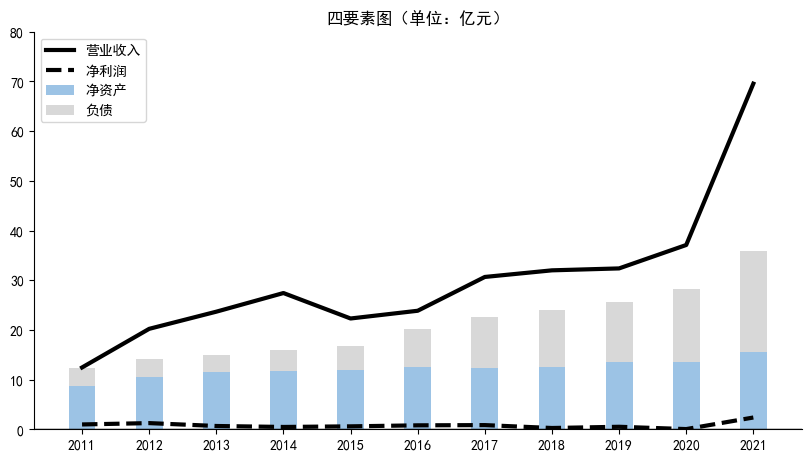

In [119]:
# 四要素图
dataset, title = zoom(TheSheet.loc[:, ['资产总计', '所有者权益合计', '负债合计', '营业总收入', '净利润']])

fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')

ax.bar(x, dataset.loc[:, '所有者权益合计'], barwidth, label='净资产', color=cm)
ax.bar(x, dataset.loc[:, '负债合计'], barwidth, dataset.loc[:, '所有者权益合计'], label='负债', color=gray)
ax.plot(x, dataset.loc[:, '营业总收入'], label='营业收入', color=black)
ax.plot(x, dataset.loc[:, '净利润'], label='净利润', color=black, linestyle='--')

ax.set_title('四要素图' + title)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.axhline(0, color='black', linewidth=1)

ax.legend() # Add a legend.

fig.savefig(path_img + '/1-1')

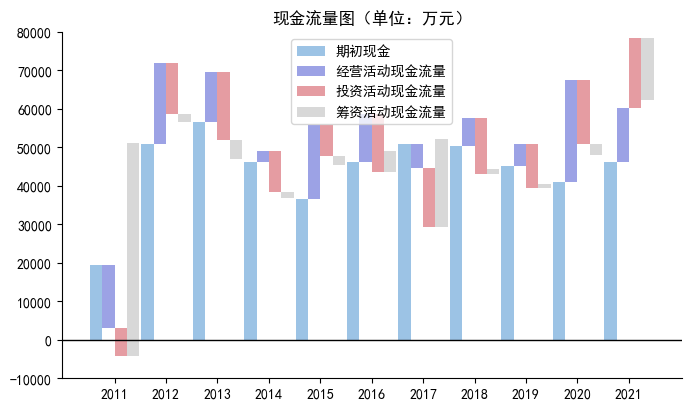

In [120]:
# 现金流量图
dataset, title = zoom(TheSheet.loc[:, ['期初现金及现金等价物余额', '经营活动产生的现金流量净额', '投资活动产生的现金流量净额', '筹资活动产生的现金流量净额']])
a, b, c, d = dataset.loc[:, '期初现金及现金等价物余额'], dataset.loc[:, '经营活动产生的现金流量净额'], dataset.loc[:, '投资活动产生的现金流量净额'], dataset.loc[:, '筹资活动产生的现金流量净额']

width = 0.24

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.bar(x_coor - width/2*3, a, width, label='期初现金', color=cm)
ax.bar(x_coor - width/2, b, width, a, label='经营活动现金流量', color=cn1)
ax.bar(x_coor + width/2, c, width, a + b, label='投资活动现金流量', color=cn2)
ax.bar(x_coor + width/2*3, d, width, a + b + c, label='筹资活动现金流量', color=gray)

ax.set_title('现金流量图' + title)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.axhline(0, color='black', linewidth=1)

ax.set_xticks(x_coor, x)
ax.margins(x=0.05)

ax.legend() # Add a legend.

fig.savefig(path_img + '/1-2')

### 3.2.    偿债能力

#### 偿债能力总览

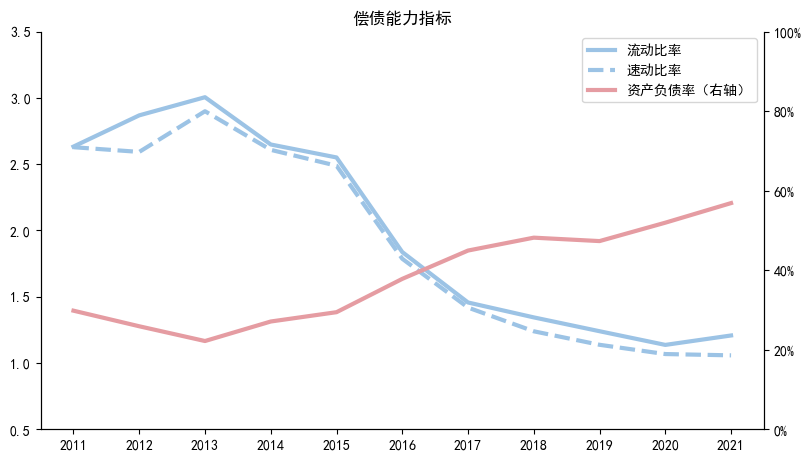

In [121]:
# 流&速动比率与资产负债率
dataset, title = zoom(TheSheet.loc[:, ['流动资产合计', '流动负债合计', '存货净额', '负债合计', '资产总计']])

fig, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
ax2 = ax1.twinx()

cr = dataset.loc[:, '流动资产合计'] / dataset.loc[:, '流动负债合计']
qr = (dataset.loc[:, '流动资产合计'] - dataset.loc[:, '存货净额'])/ dataset.loc[:, '流动负债合计']
lev = dataset.loc[:, '负债合计'] / dataset.loc[:, '资产总计'] * 100

line11, = ax1.plot(x, cr, color=cm)
line12, = ax1.plot(x, qr, color=cm, linestyle='--')
line21, = ax2.plot(x, lev, color=cn2,)

ax2.set_ylim(0, 100)
fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')

plt.title("偿债能力指标")
plt.legend((line11, line12, line21), ('流动比率', '速动比率', '资产负债率（右轴）')) # Add a legend.

fig.savefig(path_img + '/2-1')


#### 债务的期限结构

In [122]:
# 现金和债务规模
dataset, title = zoom(TheSheet.loc[:, ['货币资金', '短期借款', '一年内到期的非流动负债', '应付利息', '应付股利', '流动负债合计', '长期借款', '应付债券', '非流动负债合计']])

cash = dataset.loc[:, '货币资金']

# 短期金融负债
sfd = dataset.loc[:, '短期借款'] + dataset.loc[:, '一年内到期的非流动负债'] + dataset.loc[:, '应付利息'] + dataset.loc[:, '应付股利'] 
# 短期经营负债
sbd = dataset.loc[:, '流动负债合计'] - sfd

# 长期金融负债
lfd = dataset.loc[:, '长期借款'] + dataset.loc[:, '应付债券']
# 长期经营负债
lbd = dataset.loc[:, '非流动负债合计'] - lfd

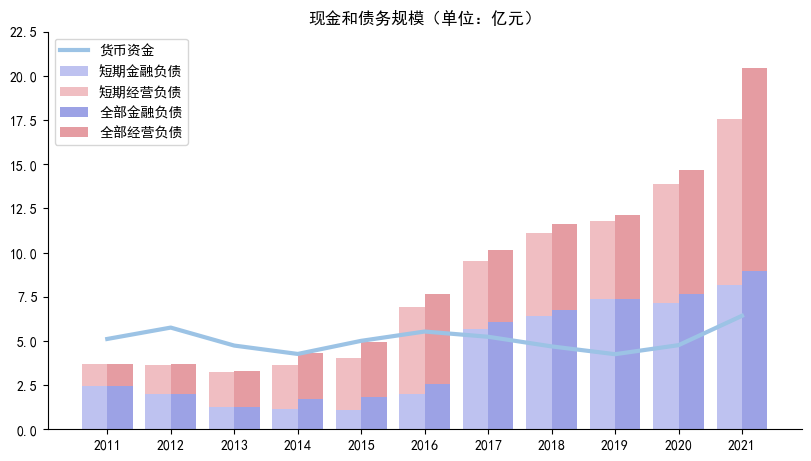

In [123]:
fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')

cn1l = lightcolor(cn1)[0]
cn2l = lightcolor(cn2)[0]

ax.bar(x_coor - barwidth/2, sfd, barwidth, color=cn1l, label='短期金融负债')
ax.bar(x_coor - barwidth/2, sbd, barwidth, color=cn2l, label='短期经营负债', bottom=sfd)
ax.bar(x_coor + barwidth/2, sfd + lfd, barwidth, color=cn1, label='全部金融负债')
ax.bar(x_coor + barwidth/2, sbd + lbd, barwidth, color=cn2, label='全部经营负债', bottom=sfd + lfd)
ax.plot(x_coor, cash, color=cm, lw=3, label='货币资金')

ax.set_xticks(x_coor, x)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.title('现金和债务规模' + title)
ax.legend()
ax.margins(x=0.05)

fig.savefig(path_img + '/2-2')

### 3.3.    盈利能力

In [124]:
dataset, title = zoom(TheSheet.loc[:, ['营业总收入', '营业成本', '净利润']])

ti = dataset.loc[:, '营业总收入']
gp = ti - dataset.loc[:, '营业成本']   # 毛利润
np = dataset.loc[:, '净利润']

gpr = gp / ti * 100 # 毛利率
npr = np / ti * 100 # 净利率

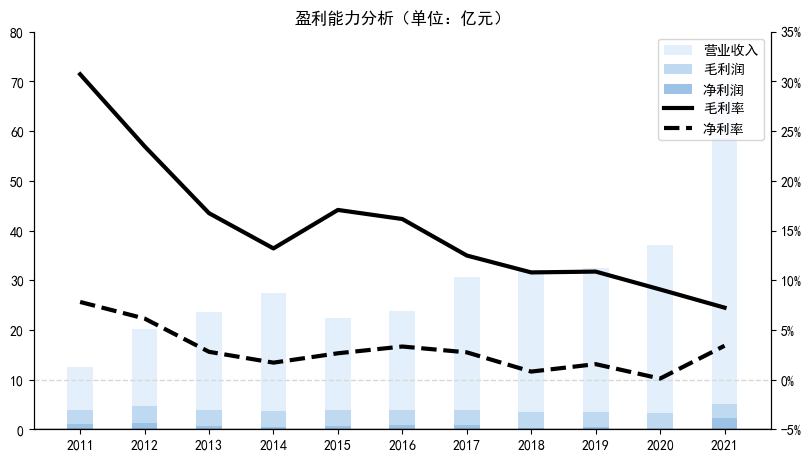

In [125]:
fig, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
ax2 = ax1.twinx()

b_ti = ax1.bar(x, ti, width=0.4, color=cm_l2)
b_gp = ax1.bar(x, gp, width=0.4, color=cm_l1)
b_np = ax1.bar(x, np, width=0.4, color=cm)
ax1.axhline(0, color=black, lw=1)
ax2.axhline(0, color=gray, lw=1, ls='--')

fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)

l_gpr, = ax2.plot(x, gpr, color=black, lw=3)
l_npr, = ax2.plot(x, npr, color=black, lw=3, ls='--')

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')
plt.title('盈利能力分析' + title)
plt.legend((b_ti, b_gp, b_np, l_gpr, l_npr), ('营业收入', '毛利润', '净利润', '毛利率', '净利率')) # Add a legend.

fig.savefig(path_img + '/3-1')

### 3.4.    周转能力/营运能力

In [126]:
dataset, title = zoom(TheSheet.loc[:, ['营业总收入', '应收账款净额', '应收票据净额', '应收款项融资', '合同资产', '营业成本', '存货净额', '预收款项', '合同负债', '应付票据', '应付账款', '预付款项净额', '货币资金']])

应收 = dataset.loc[:, '应收账款净额'] + dataset.loc[:, '应收票据净额'] + dataset.loc[:, '应收款项融资'] + dataset.loc[:, '合同资产']
应付 = dataset.loc[:, '应付票据'] + dataset.loc[:, '应付账款']

# 应收账款
rtr = dataset.loc[:, '营业总收入'] / 应收.rolling(2).mean()
rtd = 360 / rtr

# 存货
itr = dataset.loc[:, '营业成本'] / dataset.loc[:, '存货净额'].rolling(2).mean()  # 存货周转率
itd = 360 / itr # 存货周转天数

# 占用客户资金（被占用以'-'号填列）：预收 - 应收
occ = (dataset.loc[:, '预收款项'] + dataset.loc[:, '合同负债']) - 应收
# 占用供应商资金（被占用以'-'号填列）：应付 - 预付
osc = 应付 - dataset.loc[:, '预付款项净额']

# 现金周转率1：应收周转率 + 存货周转率 - 应付周转率
ctr1 = rtr + itr - (dataset.loc[:, '营业成本'] / 应付.rolling(2).mean())

# 现金周转率2
ctr2 = dataset.loc[:, '营业总收入'] / dataset.loc[:, '货币资金'].rolling(2).mean()

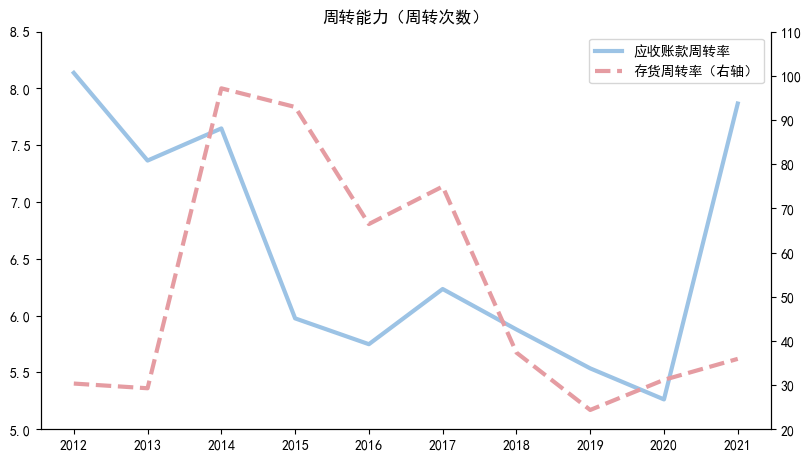

In [127]:
# 周转率
fig, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
ax2 = ax1.twinx()
l_rtr, = ax1.plot(x[1:], rtr[1:], cm)
l_itr, = ax2.plot(x[1:], itr[1:], cn2, linestyle='--')

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')

plt.title("周转能力（周转次数）")
plt.legend((l_rtr, l_itr), ('应收账款周转率', '存货周转率（右轴）')) # Add a legend.

fig.savefig(path_img + '/4-1')

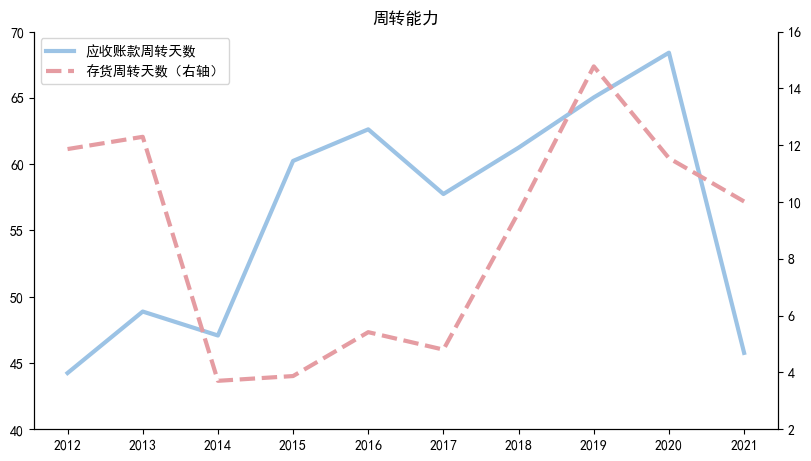

In [128]:
# 周转天数
fig, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
ax2 = ax1.twinx()
l_rtr, = ax1.plot(x[1:], rtd[1:], cm)
l_itr, = ax2.plot(x[1:], itd[1:], cn2, linestyle='--')

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')

plt.title("周转能力")
plt.legend((l_rtr, l_itr), ('应收账款周转天数', '存货周转天数（右轴）')) # Add a legend.

fig.savefig(path_img + '/4-2')

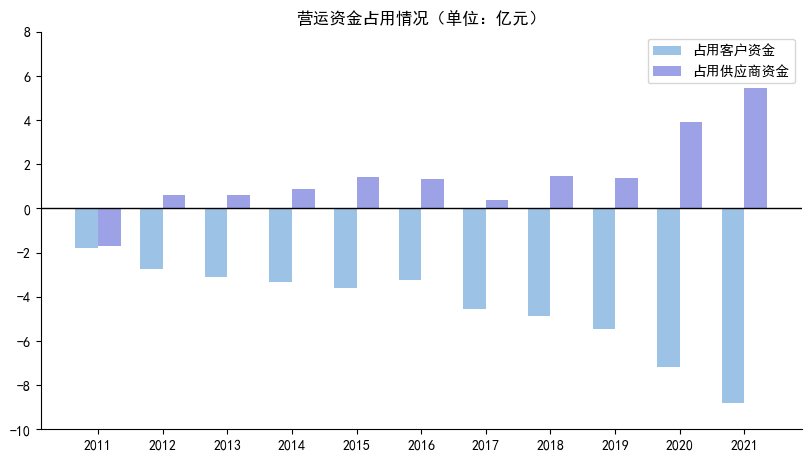

In [129]:
fig, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
ax2.twinx()

width = 0.35

b_occ = ax1.bar(x_coor - width/2, occ, color=cm, width=width, label='占用客户资金')
b_osc = ax1.bar(x_coor + width/2, osc, color=cn1, width=width, label='占用供应商资金')
#p_ctr, = ax2.plot(x_coor, ctr1, black)

ax1.set_xticks(x_coor, x)
#ax2.set_xticks(x_coor, x)

ax1.spines['top'].set_color('none')
ax1.spines['right'].set_color('none')
#ax2.spines['top'].set_color('none')

plt.title('营运资金占用情况' + title)

#plt.legend((b_occ, b_osc, p_ctr), ('占用客户资金', '占用供应商资金', '现金周转率（右轴）'))
plt.legend((b_occ, b_osc), ('占用客户资金', '占用供应商资金'))


ax1.margins(x=0.05)
ax1.axhline(0, color='black', linewidth=1)

fig.savefig(path_img + '/4-3')